In [ ]:
import re
import numpy as np
import pandas as pd
import os, glob, re
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import scipy.signal as signal
from scipy.io import savemat
import zipfile
from google.colab import files

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score

import pywt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Калиброванные индексы

PD_REMAP = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: None,
    5: 4,
    6: 5,
    7: None,
    8: None,
    9: None,
    10: None,
    11: 6,
    12: 7,
    13: 8,
    14: None,
    15: None,
    16: 9,
}

ET_REMAP = {
    0: 0,
    1: 1,
    2: None,
    3: 2,
    4: None,
    5: 3,
    6: 4,
    7: 5,
    8: 6,
    9: 7,
}


In [ ]:
base = "/content/drive/MyDrive/CAL_CSV"
et_dir = os.path.join(base, "ET")
pd_dir = os.path.join(base, "PD")

def load_numeric(dir_path):
    files = glob.glob(os.path.join(dir_path, "*.csv"))
    pairs = []
    for p in files:
        name = os.path.splitext(os.path.basename(p))[0]
        m = re.search(r"\d+", name)
        if m:
            pairs.append((int(m.group()), p))
    pairs.sort(key=lambda x: x[0])

    idx = [i for i, _ in pairs]
    dfs = [pd.read_csv(p) for _, p in pairs]

    if idx and idx != list(range(min(idx), max(idx) + 1)):
        missing = sorted(set(range(min(idx), max(idx) + 1)) - set(idx))
        print("Missing indices:", missing)

    return dfs, idx

df_et, et_idx = load_numeric(et_dir)
df_pd, pd_idx = load_numeric(pd_dir)

print("ET:", len(df_et), "files", "min/max:", (min(et_idx), max(et_idx)) if et_idx else None)
print("PD:", len(df_pd), "files", "min/max:", (min(pd_idx), max(pd_idx)) if pd_idx else None)

if df_et:
    print("ET columns:", list(df_et[0].columns))
if df_pd:
    print("PD columns:", list(df_pd[0].columns))


Missing indices: [3, 5]
Missing indices: [5, 8, 9, 10, 11, 15, 16]
ET: 8 files min/max: (1, 10)
PD: 10 files min/max: (1, 17)
ET columns: ['EOG_left_h', 'EOG_right_h', 'EOG_left_v', 'EOG_right_v', 'head_horizontal', 'head_frontal', 'head_sagittal']
PD columns: ['EOG_left_h', 'EOG_right_h', 'EOG_left_v', 'EOG_right_v', 'head_horizontal', 'head_frontal', 'head_sagittal']


In [ ]:
df_et[0]

,EOG_left_h,EOG_right_h,EOG_left_v,EOG_right_v,head_horizontal,head_frontal,head_sagittal
0,27.620691,3.536544,-41.981998,43.679216,0.000000,0.000000,0.000000
1,27.620691,3.536544,-41.981998,43.679216,-0.000323,0.000638,0.001129
2,27.620691,3.536544,-41.981998,43.679216,-0.000645,0.001275,0.002256
3,27.620691,3.536544,-41.981998,43.679216,-0.000967,0.001909,0.003381
4,27.620691,3.536544,-41.981998,43.679216,-0.001289,0.002542,0.004502
...,...,...,...,...,...,...,...
12994,-49.180167,22.487833,19.062803,-49.299531,-0.000883,0.003866,0.007286
12995,-49.180167,22.487833,19.062803,-49.299531,-0.000715,0.003143,0.005884
12996,-49.180167,22.487833,19.062803,-49.299531,-0.000545,0.002420,0.004481
12997,-49.180167,22.487833,19.062803,-49.299531,-0.000375,0.001698,0.003077


In [ ]:

"""




from scipy.signal import butter, filtfilt, detrend

EOG_COLS = ["EOG_left_h", "EOG_right_h", "EOG_left_v", "EOG_right_v"]

def butter_filter(x, fs, low=None, high=None, order=3):
    nyq = fs / 2.0
    if (low is not None and high is not None):
        btype = "bandpass"
        Wn = [low/nyq, high/nyq]
    elif (high is not None):
        btype = "lowpass"
        Wn = high/nyq
    elif (low is not None):
        btype = "highpass"
        Wn = low/nyq
    else:
        return x
    b, a = butter(order, Wn, btype=btype)
    return filtfilt(b, a, x)

def detrend_and_butter_inplace(df, fs, low=0.05, high=20.0, order=3):
    for col in EOG_COLS:
        if col not in df.columns:
            raise KeyError(f"В файле нет колонки '{col}'. Есть: {list(df.columns)}")

        x = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)

        x = detrend(x, type="linear")
        x = x - np.nanmedian(x)

        if np.any(~np.isfinite(x)):
            med = np.nanmedian(x)
            x = np.where(np.isfinite(x), x, med)

        df[col] = butter_filter(x, fs=fs, low=low, high=high, order=order)
    return df

fs = 500
df_et = [detrend_and_butter_inplace(df, fs=fs) for df in df_et]
df_pd = [detrend_and_butter_inplace(df, fs=fs) for df in df_pd]

print("Preprocessing done. Example shapes:", df_et[0].shape if df_et else None, df_pd[0].shape if df_pd else None)



"""

'\n\n\n\n\nfrom scipy.signal import butter, filtfilt, detrend\n\nEOG_COLS = ["EOG_left_h", "EOG_right_h", "EOG_left_v", "EOG_right_v"]\n\ndef butter_filter(x, fs, low=None, high=None, order=3):\n    nyq = fs / 2.0\n    if (low is not None and high is not None):\n        btype = "bandpass"\n        Wn = [low/nyq, high/nyq]\n    elif (high is not None):\n        btype = "lowpass"\n        Wn = high/nyq\n    elif (low is not None):\n        btype = "highpass"\n        Wn = low/nyq\n    else:\n        return x\n    b, a = butter(order, Wn, btype=btype)\n    return filtfilt(b, a, x)\n\ndef detrend_and_butter_inplace(df, fs, low=0.05, high=20.0, order=3):\n    for col in EOG_COLS:\n        if col not in df.columns:\n            raise KeyError(f"В файле нет колонки \'{col}\'. Есть: {list(df.columns)}")\n\n        x = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)\n\n        x = detrend(x, type="linear")\n        x = x - np.nanmedian(x)\n\n        if np.any(~np.isfinite(x)):\n  

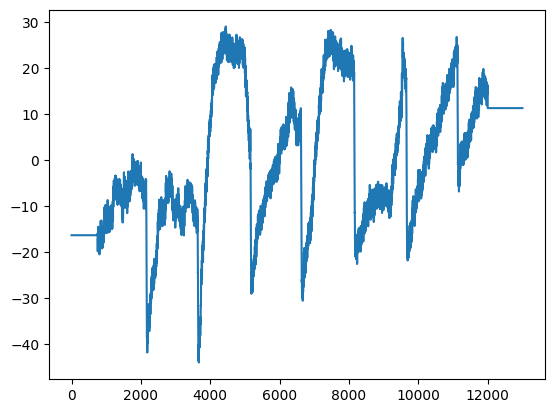

In [ ]:
plt.plot(df_pd[5]["EOG_left_v"])

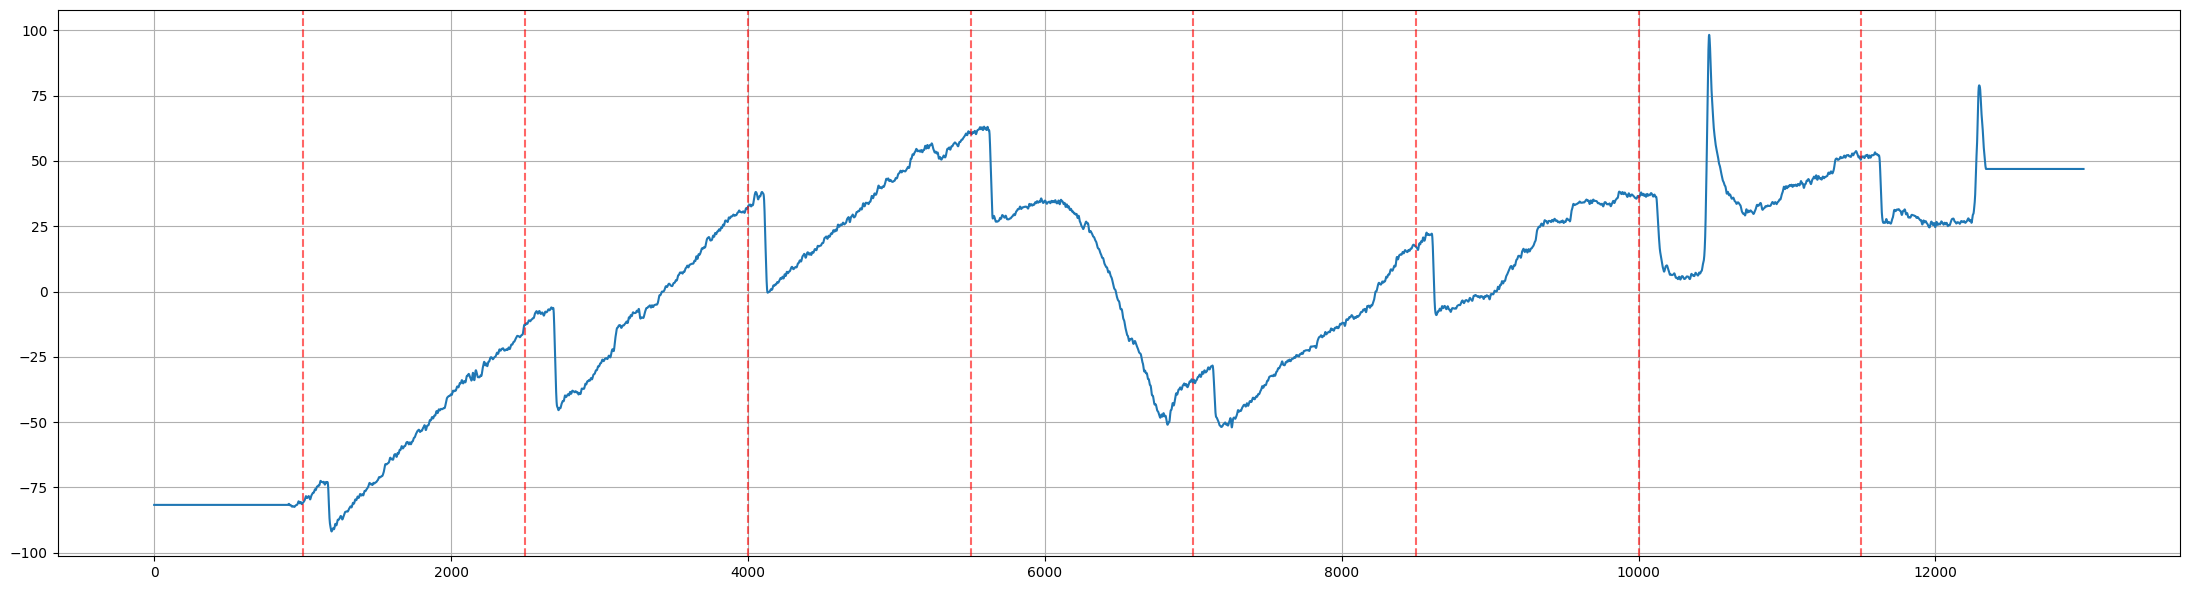

In [ ]:
impulses = [1000, 2500, 4000, 5500, 7000, 8500, 10000, 11500]

s = df_et[3]["EOG_left_v"].to_numpy()

plt.figure(figsize=(22, 6))
plt.plot(s)

for x in impulses:
    plt.axvline(x, linestyle="--", alpha=0.6, color="red")

plt.grid()
plt.tight_layout()
plt.show()

# Статистика амплитуд

In [ ]:
from scipy import stats

In [ ]:
impulses = [1000, 2500, 4000, 5500, 7000, 8500, 10000, 11500]

segments = list(zip(impulses[1:-1], impulses[2:]))
segment_names = [f"{a}-{b}" for a, b in segments]

# КАНАЛ
col = "EOG_left_h"

# амплитуда:
AMP_MODE = "ptp"
Q_LOW, Q_HIGH = 5, 95
BASELINE_N = 200

#!!!!обрезка амплитуд
AMP_MIN = None            # мин
AMP_MAX = 40              # макс
CUT_MODE = "filter"


def _to_finite(y: np.ndarray) -> np.ndarray:
    y = np.asarray(y, dtype=float)
    if np.all(np.isfinite(y)):
        return y
    m = np.isfinite(y)
    if m.sum() == 0:
        return np.full_like(y, np.nan)
    idx = np.arange(len(y))
    y2 = y.copy()
    y2[~m] = np.interp(idx[~m], idx[m], y[m])
    return y2


def segment_amplitude(seg: np.ndarray,
                      mode="ptp",
                      q_low=5, q_high=95,
                      baseline_n=200) -> float:
    seg = _to_finite(seg)
    if seg.size < 3 or not np.any(np.isfinite(seg)):
        return np.nan

    if mode == "ptp":
        return float(np.nanmax(seg) - np.nanmin(seg))

    raise ValueError(f"Unknown mode={mode}")


def apply_amp_cut(df_long: pd.DataFrame,
                  amp_min=None, amp_max=None,
                  cut_mode="filter") -> pd.DataFrame:
    out = df_long.copy()

    if amp_min is None and amp_max is None:
        return out

    if cut_mode == "filter":
        m = np.isfinite(out["amp"].values)
        if amp_min is not None:
            m &= out["amp"].values >= amp_min
        if amp_max is not None:
            m &= out["amp"].values <= amp_max
        return out.loc[m].reset_index(drop=True)

    if cut_mode == "clip":
        lo = -np.inf if amp_min is None else amp_min
        hi =  np.inf if amp_max is None else amp_max
        out["amp"] = np.clip(out["amp"].values, lo, hi)
        return out

    raise ValueError(f"Unknown cut_mode={cut_mode}")


In [ ]:
def build_amp_long(dfs, idx_list, group_name: str, col: str, segments):         #Подсчёт амплитуд
    rows = []
    for k, df in enumerate(dfs):
        pid = idx_list[k] if idx_list is not None else (k + 1)

        if col not in df.columns:
            raise KeyError(f"[{group_name}/{pid}] нет колонки '{col}'. Есть: {list(df.columns)}")

        x = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)

        for (a, b) in segments:
            a2 = max(0, int(a))
            b2 = min(len(x), int(b))
            if b2 - a2 < 3:
                amp = np.nan
            else:
                amp = segment_amplitude(
                    x[a2:b2],
                    mode=AMP_MODE, q_low=Q_LOW, q_high=Q_HIGH, baseline_n=BASELINE_N
                )

            rows.append({
                "group": group_name,
                "patient_id": pid,
                "segment": f"{a}-{b}",
                "a": a, "b": b,
                "amp": amp
            })

    return pd.DataFrame(rows)



amp_pd = build_amp_long(df_pd, pd_idx if "pd_idx" in globals() else None, "PD", col, segments)
amp_et = build_amp_long(df_et, et_idx if "et_idx" in globals() else None, "ET", col, segments)

amp_long = pd.concat([amp_pd, amp_et], ignore_index=True)

# обрезка по порогам
amp_long = apply_amp_cut(amp_long, AMP_MIN, AMP_MAX, CUT_MODE)

# составление таблицы
amp_wide = (amp_long.pivot_table(index=["group", "patient_id"], columns="segment", values="amp", aggfunc="first").reset_index())

print("amp_long:", amp_long.shape)
display(amp_long.head())
print("amp_wide:", amp_wide.shape)
display(amp_wide.head())


amp_long: (70, 6)


,group,patient_id,segment,a,b,amp
0,PD,1,2500-4000,2500,4000,24.971627
1,PD,1,4000-5500,4000,5500,17.381030
2,PD,1,5500-7000,5500,7000,22.458177
3,PD,1,10000-11500,10000,11500,18.487377
4,PD,2,2500-4000,2500,4000,24.182977


amp_wide: (13, 8)


segment,group,patient_id,10000-11500,2500-4000,4000-5500,5500-7000,7000-8500,8500-10000
0,ET,1,14.569419,9.825966,15.693038,17.802373,14.790315,21.507188
1,ET,2,18.805652,23.840179,18.512547,24.117700,15.808472,29.651524
2,ET,4,6.313291,21.571044,9.112567,5.072037,9.840963,9.883249
3,ET,7,32.701785,NaN,NaN,NaN,NaN,NaN
4,ET,8,17.271171,27.210685,26.228481,29.171617,26.103359,38.176890


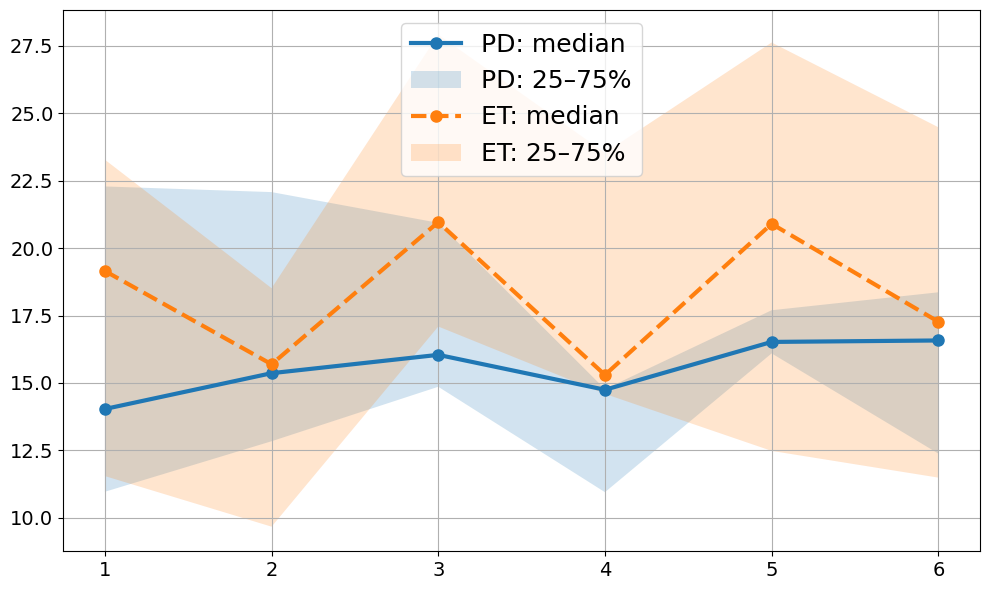

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) функция как у тебя: медиана + квантили по пациентам в каждой строке ---
def row_median_quantiles(df: pd.DataFrame, q_low=0.25, q_high=0.75):
    df = df.copy()
    patient_cols = [c for c in df.columns if c.startswith("patient_")]
    vals = df[patient_cols]

    med = vals.median(axis=1, skipna=True)
    q_lo = vals.apply(lambda row: np.nanquantile(row, q_low), axis=1)
    q_hi = vals.apply(lambda row: np.nanquantile(row, q_high), axis=1)

    if "Unnamed: 0" in df.columns:
        idx = df["Unnamed: 0"].values
        med.index = idx
        q_lo.index = idx
        q_hi.index = idx

    return med, q_lo, q_hi


# --- 2) перевод amp_long -> wide-таблица "строка=сегмент, колонки=patient_*" ---
def amp_long_to_wide(amp_long: pd.DataFrame, group_name: str, seg_order):
    sub = amp_long[(amp_long["group"] == group_name)].copy()

    wide = sub.pivot_table(
        index="segment",
        columns="patient_id",
        values="amp",
        aggfunc="first"
    )

    # фиксируем порядок сегментов как в segment_names
    wide = wide.reindex(seg_order)

    # patient_id -> patient_*
    wide.columns = [f"patient_{c}" for c in wide.columns]

    # добавим служебные колонки как в твоих latency-таблицах
    wide.insert(0, "segment", wide.index)
    wide.insert(0, "Unnamed: 0", np.arange(len(wide), dtype=int))

    wide = wide.reset_index(drop=True)
    return wide


# --- 3) строим wide для PD/ET и считаем медианы/квантили ---
wide_pd = amp_long_to_wide(amp_long, "PD", segment_names)
wide_et = amp_long_to_wide(amp_long, "ET", segment_names)

med_pd, q25_pd, q75_pd = row_median_quantiles(wide_pd)
med_et, q25_et, q75_et = row_median_quantiles(wide_et)

# --- 4) График: median + [Q25; Q75] (PD vs ET) ---
fig, ax = plt.subplots(figsize=(10, 6))

x = med_pd.index.astype(int).values + 1  # "номер сегмента" (1..N)

# PD
ax.plot(
    x, med_pd.values,
    marker='o',
    linewidth=3,
    markersize=8,
    label='PD: median'
)
ax.fill_between(
    x,
    q25_pd.values,
    q75_pd.values,
    alpha=0.2,
    label='PD: 25–75%'
)

# ET
ax.plot(
    x, med_et.values,
    marker='o',
    linewidth=3,
    markersize=8,
    linestyle='--',
    label='ET: median'
)
ax.fill_between(
    x,
    q25_et.values,
    q75_et.values,
    alpha=0.2,
    label='ET: 25–75%'
)


ax.tick_params(axis='both', labelsize=14)
ax.grid(True)
ax.legend(fontsize=18)

out_name_svg = f"PDvsET_amp_median_{col}.svg"
fig.savefig(out_name_svg, format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()

# (необязательно) подписи сегментов на оси X — если хочешь вместо номеров:
# ax.set_xticks(x)
# ax.set_xticklabels(segment_names, rotation=30, ha="right", fontsize=14)


Чек амплитууд по убыанию

In [ ]:
top_all = amp_long.sort_values("amp", ascending=False).head(30)
display(top_all)

,group,patient_id,segment,a,b,amp
57,ET,8,8500-10000,8500,10000,38.176890
29,PD,17,4000-5500,4000,5500,37.211395
60,ET,9,5500-7000,5500,7000,32.977956
52,ET,7,10000-11500,10000,11500,32.701785
61,ET,9,7000-8500,7000,8500,32.626804
63,ET,9,10000-11500,10000,11500,30.145634
44,ET,2,8500-10000,8500,10000,29.651524
55,ET,8,5500-7000,5500,7000,29.171617
53,ET,8,2500-4000,2500,4000,27.210685
54,ET,8,4000-5500,4000,5500,26.228481


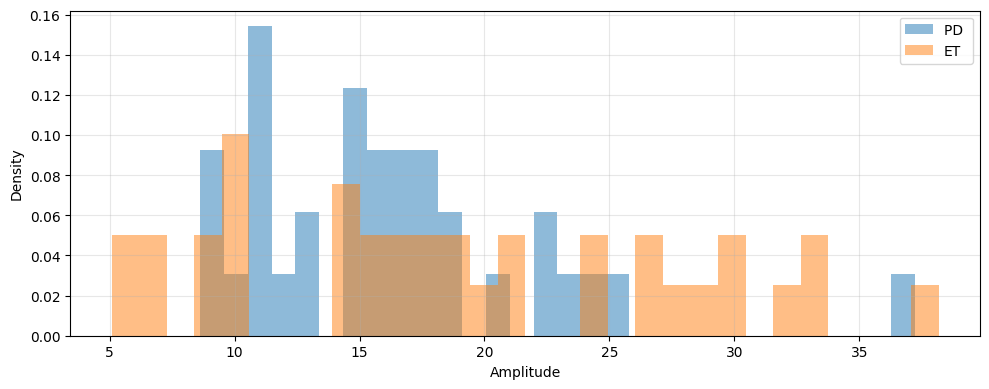

In [ ]:
pd_vals = amp_long.loc[amp_long["group"]=="PD", "amp"].dropna().values
et_vals = amp_long.loc[amp_long["group"]=="ET", "amp"].dropna().values

bins = 30
plt.figure(figsize=(10,4))
plt.hist(pd_vals, bins=bins, alpha=0.5, density=True, label=f"PD ")
plt.hist(et_vals, bins=bins, alpha=0.5, density=True, label=f"ET")
plt.xlabel("Amplitude")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Статесты

In [ ]:
rows = []

# все интервалы/сегменты считаем одной общей выборкой
x = amp_long[amp_long["group"] == "PD"]["amp"].dropna().values
y = amp_long[amp_long["group"] == "ET"]["amp"].dropna().values

def normality_p(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) < 3:
        return np.nan
    if len(x) <= 5000:
        return float(stats.shapiro(x).pvalue)
    return float(stats.normaltest(x).pvalue)

if len(x) < 3 or len(y) < 3:
    rows.append({
        "segment": "ALL",
        "n_PD": len(x), "n_ET": len(y),
        "p_shapiro_PD": np.nan, "p_shapiro_ET": np.nan,
        "p_levene": np.nan,
        "p_bm": np.nan, "p_mwu": np.nan, "p_welch": np.nan,
        "cliffs_delta": np.nan,
        "median_PD": np.nan, "median_ET": np.nan, "median_diff(PD-ET)": np.nan
    })
else:
    p_norm_x = normality_p(x)
    p_norm_y = normality_p(y)

    # Brunner–Munzel
    try:
        p_bm = float(stats.brunnermunzel(x, y, alternative="two-sided").pvalue)
    except Exception:
        p_bm = np.nan

    # Mann–Whitney
    try:
        p_mwu = float(stats.mannwhitneyu(x, y, alternative="two-sided", method="auto").pvalue)
    except Exception:
        p_mwu = np.nan


    rows.append({
        "p_shapiro_PD": p_norm_x, "p_shapiro_ET": p_norm_y,
        "p_bm": p_bm, "p_mwu": p_mwu,
        "median_PD": float(np.median(x)),
        "median_ET": float(np.median(y)),
    })

stats_df = pd.DataFrame(rows)
display(stats_df)


,p_shapiro_PD,p_shapiro_ET,p_bm,p_mwu,median_PD,median_ET
0,0.002938,0.202131,0.282438,0.266801,15.765863,17.536772


Таким образом: <br>
Шапиор: <br>
PD 0.131>0.5 распределение м.б. норм <br>
ET 0.041<0.5 нормальность отвергается, но всё же близко к пороговому значению <br>


Брюнер-Мюнцель:
0.889 >> 0.05 -> статзначимового различия между PD и ET нет

Манн-Витни:
0.894 >> 0.05 -> различия нет
Медианы пока мало толку из-за обрезания и малости выборки..




# Проверка возраста

In [ ]:
import numpy as np
from scipy import stats

pd_ages = np.array([44, 60, 47, 82, 66, 50, 79, 58, 54, 39], dtype=float)
et_ages = np.array([33, 74, 80, 41, 68, 53, 51, 19], dtype=float)

res = stats.mannwhitneyu(pd_ages, et_ages, alternative="two-sided", method="exact")
print(res)


MannwhitneyuResult(statistic=np.float64(46.0), pvalue=np.float64(0.6334384569678687))
